# Forward modelling with EMagPy
This notebook aims at presenting the Python API of the EMagPy project (https://gitlab.com/hkex/emagpy). The Python API is the working core of EMagPy and is what the GUI is calling for processing the data. The advantage of the Python API over the GUI is that is allows more automated task to be written but also interactive execution in a jupyter notebook.

The `emagpy` Python module can be downloaded from the website (running from source) or installed using `pip install emagpy`. Let's first import the needed packages.

> NOTE: execute each code cell can by pressing `Shift`+`Enter` or the play button of the interface.

In [1]:
# adding the source path of emagpy to the PATH (only needed when run from source)
import sys
sys.path.append('../src/')

# import modules
from emagpy import Problem
import numpy as np

## Introduction

In this challenge the goal is to explore the synthetic modelling capabilities of EMagPy. The main class of the EMagPy is the `Problem` class, it contains methods for inverting (`Problem.invert()`) and modelling (`Problem.forward()`).

In this example, the goal will be to generate noisy data for the following synthetic case and invert them. For this we will use the `Problem.forward()` and `Problem.invert()` methods.

![fwdmod](image/fwdmod.png)

Data will be generated for the specifications of the GF Instruments CMD Explorer device for the case when the device is operated at ground level (0 m) and 1 m elevation. This generation of synthetic data, and subsequent inverse modelling, can be done in 4 simple steps:

## 1. Define model parameters

In [2]:
nlayer = 2 # number of layers in model
npos = 30 # number of positions/sampling locations
x = np.linspace(0, 2*np.pi, npos)[:,None] # specify x position along transect
depths = 0.5 + (1+np.sin((x))) # generate depth based on x position along transect (positive!)
conds = np.ones((npos, nlayer))*[5, 35] # electrical conductivity in mS/m of upper and lower layer

## 2. Define device setup (coil configuration, frequency, height above ground)
In EMagPy device setup can be specified using the following:
- coil orientation: VCP (Vertical Co-Planar), HCP (Horizontal Co-Planar) or PRP (PeRPendicular)
- coil separation: separation between transmitter and receiver coil in metres
- frequency: operating frequency in Hz
- height above ground: operation height in metres

e.g. `VCP0.32f30000h1` is decomposed as:
- `VCP` orientation
- with `0.32` m coil separation
- operating at `30000` Hz frequency
- at `1` m above the ground.

For instance the device setup for the GF Instruments CMD Explorer operated at ground level are as follows:

In [3]:
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0', 'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']

## 3. Generate synthetic data

After creating an instance of the `Problem` class using `k = Problem()`. The conductivity model and the depth created at step 1 can be assigned using `k.setModels([depths], [conds])`.

Then `k.forward()` can be called with the following choice of arguments:
- `forwardModel` specifies the forward model to use, choose from `CS`, `FSeq`, and `FSlin`:
    - `CS` refers to the cumulative sensitivity function described by McNeil et al. (1980)
    - `FSlin` refers to a Maxwell function with conversion to ECa using Low Induction Number approximation described by McNeil et al. (1980)
    - `FSeq` refers to a Maxwell function with conversion to ECa using method described by [Andrade et al. (2016)](https://doi.org/10.3997/2214-4609.201602080)
- `noise` specifies the random (Gaussian) noise to be added to the data, e.g. `noise=0.02` means 2% noise

For example 5% noise data for the GF CMD Explorer and the above synthetic model could be generated using `FSeq` by: 

`k.forward(forwardModel='FSeq', coils=coils0, noise=0.05)`

The generated apparent ECa values can then be shown by: `k.show()`

Forward modelling


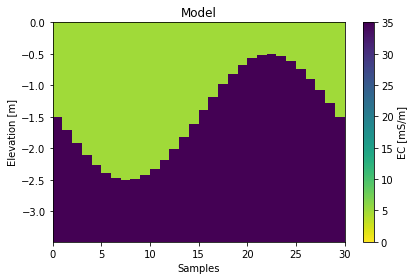

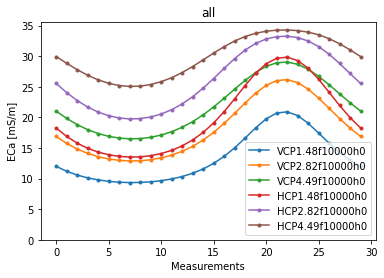

In [4]:
k = Problem() # create an instance of the Problem class
k.setModels([depths], [conds]) # create synthetic model based on conductivities and depths defined in step 1
k.forward(forwardModel='CS', coils=coils0, noise=0.00) # perform forward modellling
k.showResults(vmin=0) # show the model
k.show(vmin=0) # show the synthetic ECa generated

## 4. Invert synthetic data

First of all, the initial model needs to be specified using `setInit()`.

For instance `k.setInit(depths0=[0.5, 1], fixedDepths=[False, True], conds0=[30, 20, 20], fixedConds=[True, False, False])` specifies a 3 layers model with the bottom of the first layer at -0.5 m and the bottom of the second layer at -1 m (the third layer goes to $-\infty$). The depth of first layer is fixed while the depth of the second layer can vary during the inversion. The EC of the first layer is 30 mS/m and is fixed while the EC of the other layers is 20 mS/m an can vary during the inversion.


As with `forward()`, `invert()` uses several key arguments:
- `forwardModel` is required as described above.
- `method` specifies whether deterministic methods (`L-BFGS-B`, `CG`) or probablistic methods (`ROPE`, `SCEUA`) should be used.
- `regularization` specifies whether `l1` or `l2` regularization is used
- `njobs` specifies how many cores to use in parallel, `-1` will use all available cores, `-2` will use all but 1 core, otherwise a number can be specified
- `alpha` determines the influence of model misfit on the total misfit of the inverse problem

e.g. `k.invert(method='ROPE',forwardModel='FSeq', rep=6000, alpha=0, regularization='l1', njobs=-1)`

The results can then be shown using `k.showResults()` and the misfit can be assessed using `k.showOne2one()` or `k.showMisfit()`.

Note that here as a probabilistic inversion method is used `k.showResults(errorbars=True)` can be specified to error bars representing the standard deviation of the posterior distribution (posterior distribution based on the 10% best samples).

  0%|          | 0/30 [00:00<?, ?it/s]

Survey 1/1


100%|██████████| 30/30 [00:10<00:00,  4.14it/s]


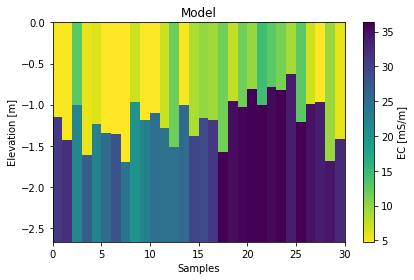

In [5]:
k.setInit(depths0=[1.5], fixedDepths=[False], # setting initial model and specify which are fixed
          conds0=[20, 20], fixedConds=[False, False])
k.invert(method='ROPE',forwardModel='CS', rep=300, alpha=0, regularization='l1', njobs=-1) # inversion
k.showResults() # show inverted model

## Summary

Forward modelling


  0%|          | 0/30 [00:00<?, ?it/s]

Survey 1/1


100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


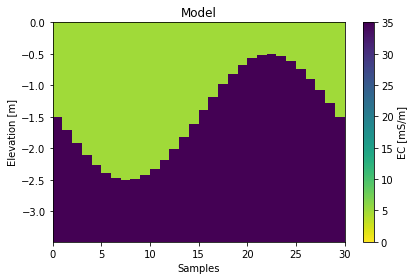

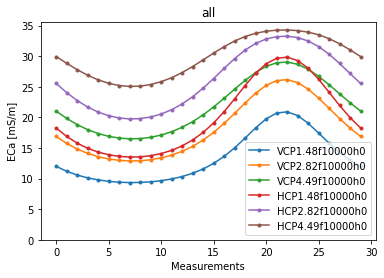

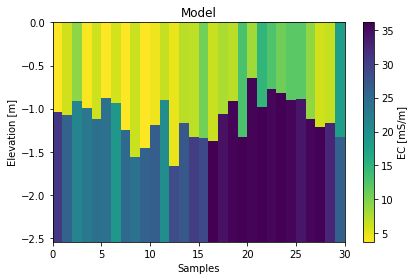

In [6]:
# =================== summary ========================
# define model parameters
nlayer = 2 # number of layers in model
npos = 30 # number of positions/sampling locations
x = np.linspace(0, 2*np.pi, npos)[:,None] # specify x position along transect
depths = 0.5 + (1+np.sin((x))) # generate depth based on x position along transect (positive!)
conds = np.ones((npos, nlayer))*[5, 35] # electrical conductivity in mS/m of upper and lower layer

# define coil orientations
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0', 'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']

# forward
k = Problem() # create an instance of the Problem class
k.setModels([depths], [conds]) # create synthetic model based on conductivities and depths defined in step 1
k.forward(forwardModel='CS', coils=coils0, noise=0.00) # perform forward modellling
k.showResults(vmin=0) # show the model
k.show(vmin=0) # show the synthetic ECa generated

# invert
k.setInit(depths0=[1.5], fixedDepths=[False], # setting initial model and specify which are fixed
          conds0=[20, 20], fixedConds=[False, False])
k.invert(method='ROPE',forwardModel='CS', rep=300, alpha=0, regularization='l1', njobs=-1) # inversion
k.showResults() # show inverted model

## Challenge 1: at one meter

If you have gotten this far we can presume the challenge has been accepted!

Reusing the code described in the previous cells generate a synthetic data with **2%** noise for the GF CMD Explorer operated at **1 m** above the ground and invert it with a **fixed first layer** conductivity at **5 mS/m** using an **L2** regularisation.

Forward modelling


  0%|          | 0/30 [00:00<?, ?it/s]

Survey 1/1


100%|██████████| 30/30 [00:03<00:00,  7.94it/s]


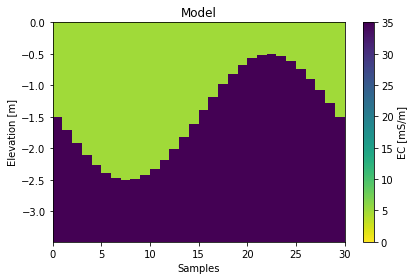

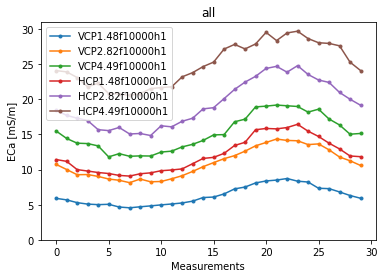

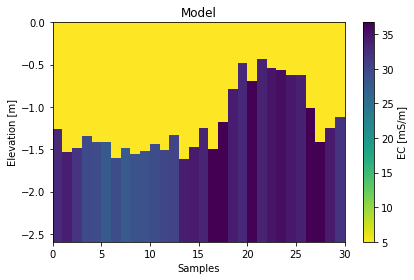

In [7]:
# ANSWER
# define model parameters
nlayer = 2 # number of layers in model
npos = 30 # number of positions/sampling locations
x = np.linspace(0, 2*np.pi, npos)[:,None] # specify x position along transect
depths = 0.5 + (1+np.sin((x))) # generate depth based on x position along transect (positive!)
conds = np.ones((npos, nlayer))*[5, 35] # electrical conductivity in mS/m of upper and lower layer

# define coil orientations
coils0 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1', 'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# forward
k = Problem() # create an instance of the Problem class
k.setModels([depths], [conds]) # create synthetic model based on conductivities and depths defined in step 1
k.forward(forwardModel='CS', coils=coils0, noise=0.02) # perform forward modellling
k.showResults(vmin=0) # show the model
k.show(vmin=0) # show the synthetic ECa generated

# invert
k.setInit(depths0=[1.5], fixedDepths=[False], # setting initial model and specify which are fixed
          conds0=[5, 20], fixedConds=[True, False])
k.invert(method='ROPE',forwardModel='CS', rep=300, alpha=0, regularization='l2', njobs=-1) # inversion
k.showResults() # show inverted model

# Challenge 2: new model

Now generate ECa values over a two layer model with layer 1 = 100 mS/m and layer 2 = 40 mS/m. The device is operated **1 m** above the ground and a  **2 %** noise is assumed. Invert them without fixing the EC of any layers.

  0%|          | 0/30 [00:00<?, ?it/s]

Forward modelling
Survey 1/1


100%|██████████| 30/30 [00:03<00:00,  8.57it/s]


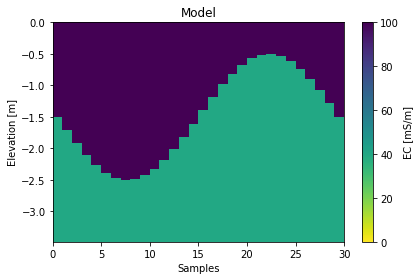

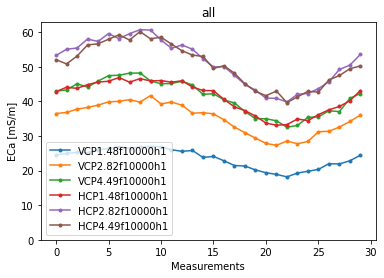

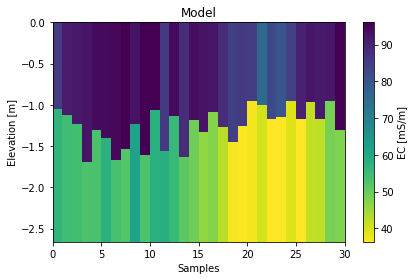

In [8]:
# ANSWER
# define model parameters
nlayer = 2 # number of layers in model
npos = 30 # number of positions/sampling locations
x = np.linspace(0, 2*np.pi, npos)[:,None] # specify x position along transect
depths = 0.5 + (1+np.sin((x))) # generate depth based on x position along transect (positive!)
conds = np.ones((npos, nlayer))*[100, 40] # electrical conductivity in mS/m of upper and lower layer

# define coil orientations
coils0 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1', 'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# forward
k = Problem() # create an instance of the Problem class
k.setModels([depths], [conds]) # create synthetic model based on conductivities and depths defined in step 1
k.forward(forwardModel='CS', coils=coils0, noise=0.02) # perform forward modellling
k.showResults(vmin=0) # show the model
k.show(vmin=0) # show the synthetic ECa generated

# invert
k.setInit(depths0=[1.5], fixedDepths=[False], # setting initial model and specify which are fixed
          conds0=[5, 20], fixedConds=[False, False])
k.invert(method='ROPE',forwardModel='CS', rep=300, alpha=0, regularization='l2', njobs=-1) # inversion
k.showResults() # show inverted model

# Challenge 3: FS forward model

Using Challenge 2 example, use the full Maxwell forward model with LIN assumption (`FSlin`) to produce and invert data.

Forward modelling


 23%|██▎       | 7/30 [00:00<00:00, 40.58it/s]

Survey 1/1


100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


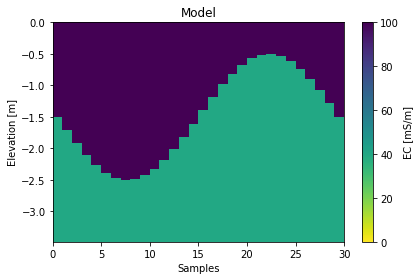

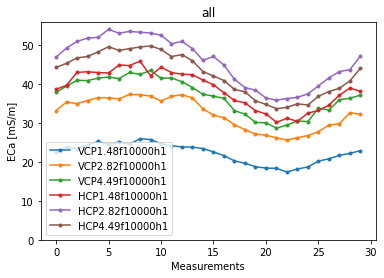

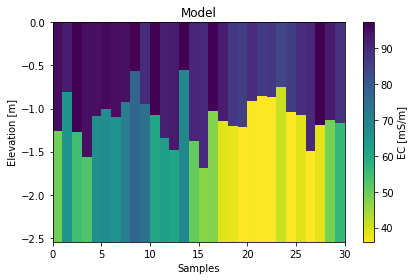

In [9]:
# ANSWER
# define model parameters
nlayer = 2 # number of layers in model
npos = 30 # number of positions/sampling locations
x = np.linspace(0, 2*np.pi, npos)[:,None] # specify x position along transect
depths = 0.5 + (1+np.sin((x))) # generate depth based on x position along transect (positive!)
conds = np.ones((npos, nlayer))*[100, 40] # electrical conductivity in mS/m of upper and lower layer

# define coil orientations
coils0 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1', 'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# forward
k = Problem() # create an instance of the Problem class
k.setModels([depths], [conds]) # create synthetic model based on conductivities and depths defined in step 1
k.forward(forwardModel='FSlin', coils=coils0, noise=0.02) # perform forward modellling
k.showResults(vmin=0) # show the model
k.show(vmin=0) # show the synthetic ECa generated

# invert
k.setInit(depths0=[1.5], fixedDepths=[False], # setting initial model and specify which are fixed
          conds0=[5, 20], fixedConds=[False, False])
k.invert(method='ROPE',forwardModel='FSlin', rep=300, alpha=0, regularization='l2', njobs=-1) # inversion
k.showResults() # show inverted model